# 0. Import, data read, function definition

In [1]:
import os, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_squared_error

In [2]:
!ls data

sample_submission.csv  test.csv  train.csv


In [3]:
test = pd.read_csv("data/test.csv")
train = pd.read_csv("data/train.csv")

print(train.columns)

Index(['id', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7',
       'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14',
       'target'],
      dtype='object')


In [9]:
X_test = test.iloc[:,1:]
X_train = train.iloc[:,1:-1]
Y_train = train.iloc[:,-1]

# get id, useful for kaggle subsmission
test_id = test.id
train_id = train.id

print(X_test.shape, X_train.shape, Y_train.shape) 
# our input space has 14 dimensions
# with 200 000 test examples, and 300 000 train examples
# output space has 1 dimension

(200000, 14) (300000, 14) (300000,)


In [10]:
def kernelize(X,kernel="linear"):
    """
    inputs:
        apply linear kernel to our data
        X : pandas dataframe, containing dimensions in columns
    returns :
        X_new : dataframe resulting of the application of the kernel on X dataframe
    """
    new_X = []
    X_columns = X.columns
    N_columns = len(X.columns)
    new_columns = []
    if kernel =="linear" or kernel=="exponential":
        for i in range(N_columns):
            for j in range(N_columns):
                if i <= j : # since our kernel is symetric, we need can compute only half of the operations
                    col0, col1 = X_columns[i], X_columns[j]
                    new_columns.append("k(" + col0 + "," + col1 + ")")
                    if kernel == "linear":
                        new_X.append(copy.deepcopy(np.multiply(X[col0], X[col1])))
                    if kernel == "exponential":
                        new_X.append(copy.deepcopy(np.exp(X[col0] + X[col1])))


    new_X = pd.concat(new_X, axis=1)
    new_X.columns = new_columns
    return new_X

In [39]:
def make_kaggle_submission(Y, id_list, file_name = "submission.csv"):
    """
    convert Y array into the correct format for kaggle submission
    & save into csv file 
    & returns the submission
    """
    df = pd.DataFrame(Y, index=id_list, columns = ["target"])
    
    df.to_csv("data/" + file_name)
    
    return df

# 1. MKL

## 1.1. Kernel method with a chosen kernel

In [11]:
# We apply product kernel

X_test_linear_kernel = kernelize(X_test)
X_train_linear_kernel = kernelize(X_train)

print(X_train_linear_kernel.shape, X_test_linear_kernel.shape) # we get a 105 dimension space

(300000, 105) (200000, 105)


## 1.2. Ridge regression in the feature space

In [14]:
regressor = Ridge()

In [20]:
regressor.fit(X_train_linear_kernel.values, Y_train)

Ridge()

In [27]:
Y_predict = regressor.predict(X_test_linear_kernel)

In [28]:
print("predicted variance :", Y_predict.var(),"\ntraining variance :", Y_train.var())
print("\npredicted mean :", Y_predict.mean(),"\ntraining mean :", Y_train.mean())
print("\npredicted min :", Y_predict.min(),"\ntraining min :", Y_train.min())
print("\npredicted max :", Y_predict.max(),"\ntraining max :", Y_train.max())

predicted variance : 0.018928769204604 
training variance : 0.5373928423339634

predicted mean : 7.905108132030335 
training mean : 7.905661328316826

predicted min : 7.085882010461101 
training min : 0.0

predicted max : 8.830757355454702 
training max : 10.267568500800396


In [151]:
# The classifier predict values that are in a shorter interval comparing to what we get in the training set
# It would be interesting to search why
# It may be a problem if test and train sets are constructed by random sampling per example

In [40]:
make_kaggle_submission(Y_predict, id_list=test_id, file_name="submission0.csv")

# Result of this submission (RMSE = 0.72255)

,target
id,
0,8.019208
2,7.778296
6,7.938228
7,7.940062
10,8.212541
...,...
499984,8.057480
499985,7.950218
499987,7.823627


## 1.3. Multiple Kernel Learning implementation (MKL)

In [185]:
# compute exponential kernelization
X_test_exponential_kernel = kernelize(X_test, kernel="exponential")
X_train_exponential_kernel = kernelize(X_train, kernel="exponential")

In [228]:
# we compare the results of ridge regression with regularization on the custom kernel ( linear kernel + beta * exponential kernel)
beta_values = [0.01,0.05,0.1,0.5,2,5]
score_mean = []
score_variance = []
for beta in beta_values:
# We split our kernelized arrays into a test and training set

    X = X_train_linear_kernel + beta * X_train_exponential_kernel
    scores = []
    for i in range(5):
        x_train, x_test, y_train, y_test = train_test_split(X, Y_train)
    
        regressor = Ridge()
    
        regressor.fit(x_train, y_train)
    
        y_predict = regressor.predict(x_test)
        
        scores.append(mean_squared_error(y_predict, y_test)) # compute score of prediction
        
    score_mean.append(np.mean(scores))
    score_variance.append(np.var(scores)) # get mean and variance of the score for a givent beta value (multiple runs by selecting different test/train set)

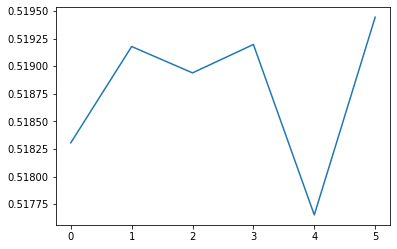

In [229]:
plt.plot(score_mean)

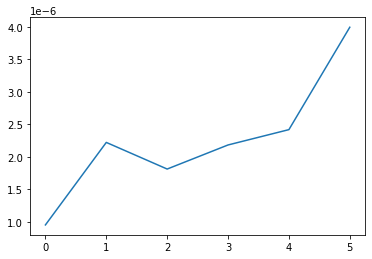

In [230]:
plt.plot(score_variance)